In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
from jax import numpy as jnp
from jax.experimental import host_callback

from tqdm.auto import tqdm
from functools import partial
import optax
import matplotlib.pyplot as plt
from pprint import pprint

from flax import linen as nn
from typing import Sequence

from functools import partial
from typing import Callable, Sequence
from flax import struct
from flax import linen as nn
import jax
import jax.numpy as jnp
import optax
from functools import partial

import qlearning
import replay
import plotting
from utils import ConvNet
from frozen_lake import EnvState, FrozenLake, ObsType, ActType, RNGKey


In [10]:
jax.devices()

[cuda(id=0)]

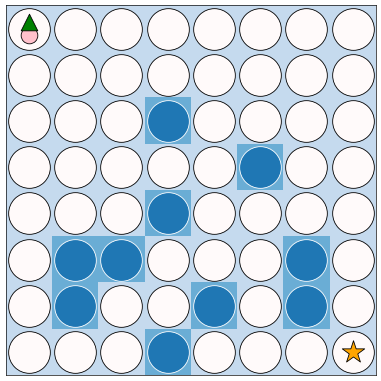

In [11]:
env = FrozenLake.make(None, (8,8))
env_state, obs = env.reset(jax.random.PRNGKey(0))
plotting.render(env, env_state)

In [12]:
from mango_utils import MangoDQLTrainState, MultiDQLTrainState, DQLTrainState
from mango_utils import eps_greedy_rollout

In [13]:
n_actions = 4
epsilons = jnp.array([0.5, 0.5, 0.5])
rng = jax.random.PRNGKey(0)

MultiConvNet = nn.vmap(
    ConvNet,
    in_axes=None,
    variable_axes={"params": 0},
    split_rngs={"params": True},
    axis_size=n_actions,
)

qnet = ConvNet([16, 16, 16], n_actions)
multiqnet = MultiConvNet([16, 16, 16], n_actions)

mango_dql_state = MangoDQLTrainState(
    outer=DQLTrainState.create(rng, qnet, obs),
    inner=[
        MultiDQLTrainState.create(rng, multiqnet, obs),
        MultiDQLTrainState.create(rng, multiqnet, obs),
    ],
    beta_fn=lambda x, y: jnp.ones(2, dtype=bool),
    reward_fn=lambda t: jnp.ones((2, n_actions), dtype=bool),
)

In [14]:
for _ in tqdm(jax.random.split(rng, 100)):
    trans = eps_greedy_rollout(env, mango_dql_state, rng, epsilons, 256)

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
class MangoTransition(struct.PyTreeNode):
    obs: ObsType  # (1+layers, ...)
    actions: ActType  # (1+layers)
    next_obs: ObsType  # (1+layers, ...)
    reward: float
    rewards_inner: jax.Array  # (layers, policy)
    betas: jax.Array  # (1+layers)
    done: bool
    info: dict

    def aggregate(self):
        def scan_body(future: MangoTransition, current: MangoTransition):
            end_obs = jnp.where(current.betas, current.next_obs, future.next_obs)
            reward = jax.lax.select(
                current.betas[0], current.reward, current.reward + future.reward
            )
            reward_inner = jnp.where(
                current.betas[1:, None],
                current.rewards_inner,
                current.rewards_inner + future.rewards_inner,
            )
            future = current.replace(
                next_obs=end_obs,
                reward=reward,
                rewards_inner=reward_inner,
                done=current.done | future.done,
            )
            return future, future

        end = jax.tree_map(lambda x: x[-1], self)
        end = end.replace(
            reward=jnp.zeros_like(end.reward), rewards_inner=jnp.zeros_like(end.rewards_inner)
        )
        _, transitions = jax.lax.scan(scan_body, end, self, reverse=True)
        return transitions